In [23]:
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt
import scipy

# parameter values
p0 = 101325  # pressure
T0 = 296  # inlet temperature
phi = 0.7  # equivalence ratio
alpha = 0.566  # volume fraction (<1)

# mdot(=mass flux, 단위 면적당 시간당 전달되는 질량)
mdot_reactants = 80  # kg/m^2/s # 반응물이 1초당 1m² 면적을 통해 80kg 만큼 들어온다
mdot_products = mdot_reactants  # kg/m^2/s # 생성물이 반응 후에 같은 속도로 배출된다, mass conservation

# Mechanism and fuel composition
xh2 = alpha / (1 - alpha) * 1  # xh2 = alpha/(1-alpha)*xc
fuel = {'CH4': 1, 'H2': xh2}
oxidizer = {'O2': 1, 'N2': 3.76}

# Calculation params
width = 0.2  # m domain width
loglevel = 0  # amount of diagnostic output (0 to 5)

In [13]:
# Gas object 1 for the counterflow flame
gas1 = ct.Solution('gri30.yaml')  # reaction mechanism file
gas1.TP = T0, p0

# fix the composition of the fuel
gas1.set_equivalence_ratio(phi, fuel, oxidizer)  # hold temperature and pressure constant

# calculate flame speed using laminar unstretched flame
flame = ct.FreeFlame(gas1, width=width)
flame.solve(loglevel, auto=True)
flame_speed = flame.velocity[0]  # flame velocity(first one)
print(f'Flame speed: {flame_speed:.5f} m/s')

# Create the counterflow premixed flame simulation object
fl1 = ct.CounterflowPremixedFlame(gas=gas1, width=width)
fl1.transport_model = 'multicomponent'
fl1.energy_enabled = True  # energy equation
fl1.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# set the boundary flow rates
fl1.reactants.mdot = mdot_reactants
fl1.products.mdot = mdot_products

fl1.set_initial_guess()  # assume adiabatic equilibrium products
fl1.solve(loglevel, auto=True)
print(fl1.products.T)

Flame speed: 0.31479 m/s
1812.8710116169764


In [14]:
# calculate velocity gradient
grad_u = np.gradient(flame.velocity, flame.grid) 

# find index that has max|du/dx|
max_grad_idx = np.argmax(np.abs(grad_u))
print(f"Index of max |du/dx|: {max_grad_idx}")

# value of max|du/dx|
max_grad_value = grad_u[max_grad_idx]
print(f"Value of max |du/dx|: {max_grad_value}")

Index of max |du/dx|: 10
Value of max |du/dx|: 2786.6408924401885


In [15]:
# calculate thermal diffusivity
cp = flame.cp_mass[0]  # specific heat capacity at constant pressure(Cp), first grid point (J/kg/K)
density = flame.density_mass[0]  # density at the first grid point (kg/m^3)
lambda_ = flame.thermal_conductivity[0]  # thermal conductivity at the first grid point (W/m/K)

thermal_diffusivity = lambda_ / (density * cp)  # thermal diffusivity calculation
print(f"Thermal diffusivity of reactants (α): {thermal_diffusivity:.5e} m^2/s")

Thermal diffusivity of reactants (α): 2.56978e-05 m^2/s


In [16]:
# calculate strain rate
Ka = thermal_diffusivity / (flame_speed * max_grad_value)
print(f"Strain rate (Ka): {Ka:.5e} 1/s")

Strain rate (Ka): 2.92952e-08 1/s


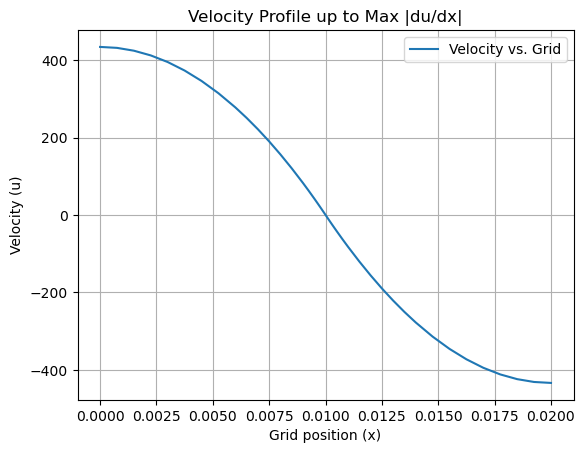

In [17]:
# left side of the index (~max_grad_idx data)
cut_grid = flame.grid[:max_grad_idx + 1]  # ~idx grid
cut_u = flame.velocity[:max_grad_idx + 1]  # ~idx velocity

# plot grid-velocity graph
# plt.plot(flame.grid, flame.velocity, label="Velocity vs. Grid")
# plt.plot(cut_grid, cut_u, label="Velocity vs. Grid (left of max |du/dx|)")
plt.plot(fl1.grid, fl1.velocity, label="Velocity vs. Grid")
plt.xlabel('Grid position (x)')
plt.ylabel('Velocity (u)')
plt.title('Velocity Profile up to Max |du/dx|')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Gas object 2 for the counterflow flame with non-equilibrium products
gas2 = ct.Solution('gri30.yaml')
gas2.TP = T0, p0
gas2.set_equivalence_ratio(phi, fuel, oxidizer)

# Create the flame simulation object
fl2 = ct.CounterflowPremixedFlame(gas=gas2, width=width)
fl2.set_refine_criteria(ratio=3, slope=0.1, curve=0.2, prune=0.02)

# set the boundary flow rates
fl2.reactants.mdot = mdot_reactants
fl2.products.mdot = mdot_products

#product temperature, temperature of my project
fl2.products.T = 1800 # Tp
fl2.products.X = fl1.products.X #composition of the products

fl2.set_initial_guess(equilibrate=False)
fl2.solve(loglevel, auto=True)
print(fl2.products.T)

1800.0


In [25]:
# get adiabatic temperature from the FreeFlame object
def get_adiabatic_temperature_from_flame(flame): # lamninar unstretched flame
    Tad = flame.T[-1]  # final status of the flame
    return Tad

Tad = get_adiabatic_temperature_from_flame(fl1)
print(f'Adiabatic temperature (Tad) from FreeFlame: {Tad:.2f} K')

Adiabatic temperature (Tad) from FreeFlame: 1812.87 K


In [20]:
def calculate_heat_loss_coefficient(Tp, Tad, Tr):
    beta = (Tp - Tr) / (Tad - Tr)
    return beta

# set parameter value
Tp = fl2.products.T # the only thing can chagne
Tr = T0

# calculate heat loss coefficient
beta = calculate_heat_loss_coefficient(Tp, Tad, Tr)
print(f'heat loss coefficient (beta): {beta:.3f}')

heat loss coefficient (beta): 0.992


In [21]:
def calculate_consumption_speed(flame, gas, fuel_species):
    # unburnt density (first point of the grid)
    rho_u = flame.density[0]  
    
    # calculate (Y_k,b - Y_k,u) for each fuel species
    mass_fraction_diff = 0
    integral_numerator = 0

    # (Y_f,u, first point)
    total_fuel_mass_fraction = 0
    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)
        total_fuel_mass_fraction += flame.Y[i_fuel, 0]

    for fuel in fuel_species:
        i_fuel = gas.species_index(fuel)  # fuel index

        # calculate Y_k,b (end value) and Y_k_u (first value)
        Y_k_b = flame.Y[i_fuel, -1]  # end point (product)
        Y_k_u = flame.Y[i_fuel, 0]   # first point (reactant)
        mass_fraction_diff += Y_k_b - Y_k_u  # sigma (Y_k,b - Y_k,u)

    # calculate nk (n_k = Y_k,u / Y_f,u)
    ih2 = gas.species_index('H2')
    Y_h2_u = flame.Y[ih2, 0]  # mass fraction
    nk_h2 = Y_h2_u / total_fuel_mass_fraction

    ich4 = gas.species_index('CH4')
    Y_ch4_u = flame.Y[ich4, 0]  # mass fraction
    nk_ch4 = Y_ch4_u / total_fuel_mass_fraction

    # integral about production rates
    integral_h2 = scipy.integrate.simpson(gas.molecular_weights[ih2] * flame.net_production_rates[ih2], x=flame.grid)
    integral_ch4 = scipy.integrate.simpson(gas.molecular_weights[ich4] * flame.net_production_rates[ich4], x=flame.grid)

    # integral_numerator update (nk*integral value)
    integral_numerator = (nk_h2 * integral_h2) + (nk_ch4 * integral_ch4)

    S_cF = integral_numerator / (rho_u * mass_fraction_diff)
    
    return S_cF

fuel_species = ['CH4', 'H2']
S_cF = calculate_consumption_speed(fl2, gas1, fuel_species)
print(f'Consumption speed S_cF: {S_cF:.5f} m/s')

Consumption speed S_cF: 0.15381 m/s


In [22]:
# Range of Ka values (logarithmic)
Ka_values = np.logspace(-2, 2, 10)  # Logarithmic range for Ka from 10^-2 to 10^2
S_cF_values = []

for Ka in Ka_values:
    # Calculate the new inlet velocity based on Ka
    inlet_velocity = Ka * width / flame.density[0]  # Example equation based on Ka and width
    flame.inlet.mdot = inlet_velocity * flame.density[0]  # 질량 유량 설정
    flame.solve(loglevel=0, auto=True)

    # Calculate consumption speed with the new boundary conditions
    S_cF = calculate_consumption_speed(fl1, gas1, fuel_species) # burnt gas
    S_cF_values.append(S_cF)
    
# print(Ka_values)
print(S_cF_values)

[0.23629613685668938, 0.23629638445577197, 0.23629638455652693, 0.2362963841880407, 0.2362963843735158, 0.23629638416058243, 0.2362963849342203, 0.23629638446471038, 0.23629638429732028, 0.23629638424927712]


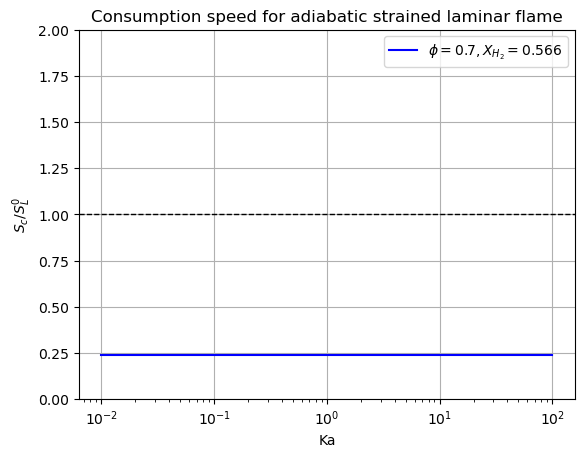

In [24]:
# Plotting the results
plt.figure()
plt.plot(Ka_values, S_cF_values, label=r'$\phi=0.7, X_{H_2}=0.566$', color='blue')
plt.axhline(y=1, color='k', linestyle='--', linewidth=1)  # stagnation line
plt.xscale('log')
plt.title('Consumption speed for adiabatic strained laminar flame')
plt.xlabel('Ka')
plt.ylabel(r'$S_c/S_L^0$')
plt.ylim(0, 2)
plt.legend()
plt.grid(True)
plt.show()